# Data Output & Visualization
This tool is designed to help you visualize and understand your spending habits by combining scanned bills and manual inputs for budget and income. The notebook is split into two main sections:

- **Part 1: Total Overview of Expenses** 
- **Part 2: Budget vs Income vs Expenses**

## Part 0: Setup & Configuration

In this section, we load the necessary libraries, import your data, and define key parameters for filtering and aggregation.

- Import libraries: pandas, matplotlib, seaborn, plotly, datetime, etc.
- Load data: Bills (scanned or manually input), monthly budget, and income
- Define adjustable parameters:
    - start_date, end_date (DD.MM.YYYY format)
    - aggregation_level: 'daily', 'monthly', 'yearly'
    - currency: 'CHF'





In [8]:
# Step 0.1: Import libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sqlalchemy import create_engine
from datetime import datetime

# Step 0.2: Load environment variables for Azure SQL
server = os.getenv("AZURE_SQL_SERVER")
database = os.getenv("AZURE_SQL_DB")
username = os.getenv("AZURE_SQL_USER")
password = os.getenv("AZURE_SQL_PASSWORD")
port = os.getenv("AZURE_SQL_PORT", "1433")

# Step 0.3: Create SQLAlchemy connection string
connection_string = (
    f"mssql+pyodbc://{username}:{password}@{server}:{port}/{database}"
    "?driver=ODBC+Driver+17+for+SQL+Server"
)
engine = create_engine(connection_string)

# Step 0.4: Load data from SQL tables
transactions = pd.read_sql("SELECT * FROM app.transactions", engine)
categories = pd.read_sql("SELECT * FROM app.categories", engine)
budgets = pd.read_sql("SELECT * FROM app.budgets", engine)

# Step 0.5: Merge category names into transactions
transactions = transactions.merge(categories, how="left", on="category_id")

# Step 0.6: Filter only expenses
expenses = transactions[transactions["type_x"] == "expense"].copy()
expenses["date"] = pd.to_datetime(expenses["date"])

## Part 1: Total Overview of Expenses
This section provides a comprehensive view of your expenses using interactive visualizations.

### 1.1 Monthly Expense Summary
This bar chart shows your total expenses over time. You can adjust the time range and choose whether to view data by day, month, or year.
- Y-axis: Expense amount in CHF
- X-axis: Time (daily/monthly/yearly)
- Filters: Adjustable date range and aggregation level


C:\Users\belin\AppData\Local\Temp\ipykernel_25620\1279728843.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  grouped = filtered.groupby(pd.Grouper(key="date", freq=aggregation_level))["amount"].sum().reset_index()


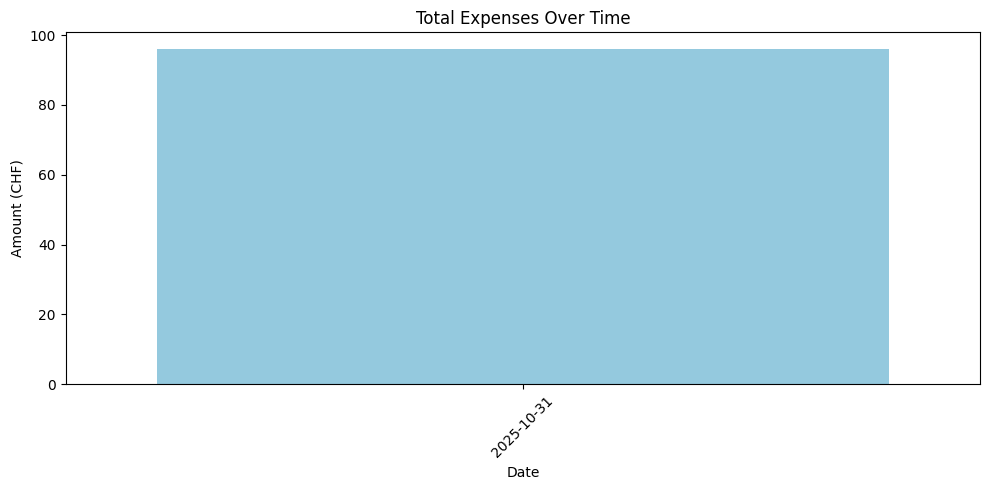

In [9]:
# Adjustable parameters
start_date = "2025-01-01"
end_date = "2025-12-31"
aggregation_level = "M"  # 'D' = daily, 'M' = monthly, 'Y' = yearly

# Filter and group
filtered = expenses[(expenses["date"] >= start_date) & (expenses["date"] <= end_date)]
grouped = filtered.groupby(pd.Grouper(key="date", freq=aggregation_level))["amount"].sum().reset_index()

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=grouped, x="date", y="amount", color="skyblue")
plt.title("Total Expenses Over Time")
plt.ylabel("Amount (CHF)")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 1.2 Expense Breakdown by Category
This pie chart displays how your expenses are distributed across categories:
- Restaurant
- Lebensmittel
- Wohnen & Haushalt
- Mobilität & Transport
- Gesundheit & Vorsorge
- Versicherungen & Finanzen
- Familie & Bildung
- Freizeit & Unterhaltung
- Sonstiges


In [13]:
# Group by category
category_summary = filtered.groupby("name")["amount"].sum().reset_index()

# Plot
fig = px.pie(category_summary, values="amount", names="name", title="Expenses by Category")
fig.update_traces(textposition="inside", textinfo="percent+label")
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

### 1.3 Monthly Category Split (Stacked Bar Chart)
This stacked bar chart shows how your monthly expenses are split across categories. Each bar represents a month, and the segments show category-wise distribution.
- X-axis: Months
- Y-axis: Expense amount in CHF
- Filters: Adjustable date range


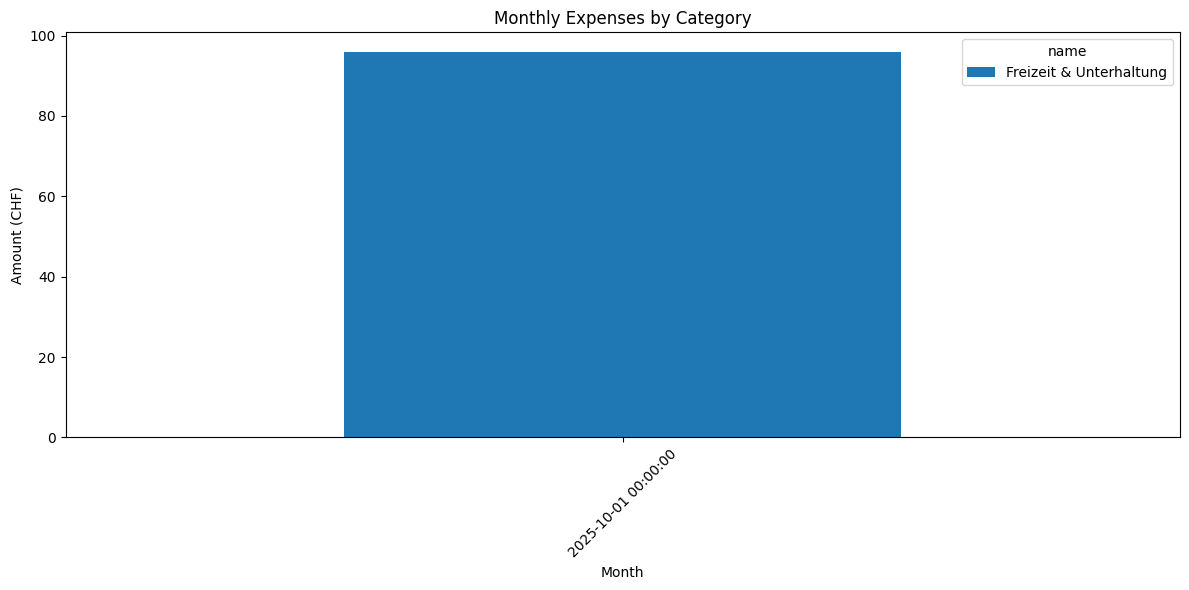

In [11]:
# Group by month and category
monthly_split = filtered.copy()
monthly_split["month"] = monthly_split["date"].dt.to_period("M").dt.to_timestamp()
pivot = monthly_split.pivot_table(index="month", columns="name", values="amount", aggfunc="sum").fillna(0)

# Plot
pivot.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab20")
plt.title("Monthly Expenses by Category")
plt.ylabel("Amount (CHF)")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Part 2: Comparison of Expenses vs Budget and Income

The database schema primarily captures expenses through the `app.transactions` table, with optional links to categories and receipts. Budget values are stored in the `app.budgets` table, defined per category and month. However, there is no dedicated table for monthly income.

## 2.0 Manual Input of Monthly Budget and Income
To enable meaningful comparisons between planned and actual financial behavior, this section introduces manually defined inputs for:
- **Total monthly budget**: representing the sum of all planned expenses across categories
- **Total monthly income**: representing expected income for each month

These values are entered at the beginning of each month and stored in dictionaries for flexibility. They are later converted into structured DataFrames and aligned with actual transaction data to support visual and tabular comparisons.

In [5]:
# Define monthly budget and income manually
# Format: {"YYYY-MM": value}
manual_budget = {
    "2025-01": 4000,
    "2025-02": 4200,
    "2025-03": 3900,
    "2025-04": 4100,
    "2025-05": 4300,
    "2025-06": 4000,
}

manual_income = {
    "2025-01": 5000,
    "2025-02": 5000,
    "2025-03": 5000,
    "2025-04": 5000,
    "2025-05": 5000,
    "2025-06": 5000,
}

# Convert to DataFrames
budget_df = pd.DataFrame(list(manual_budget.items()), columns=["month", "budget"])
income_df = pd.DataFrame(list(manual_income.items()), columns=["month", "income"])

# Ensure datetime format
budget_df["month"] = pd.to_datetime(budget_df["month"])
income_df["month"] = pd.to_datetime(income_df["month"])

# Preview
display(budget_df)
display(income_df)

NameError: name 'pd' is not defined

## 2.1 Income vs. Expenses

This section compares actual monthly income and expenses using a grouped bar chart. The goal is to visualize the financial balance for each month and identify periods of surplus or deficit.

- **Income** is shown in green bars.
- **Expenses** are shown in red bars.
- Each pair of bars represents one calendar month.

The data is aggregated from the `app.transactions` table, where:
- Income is identified by `type = 'income'`
- Expenses are identified by `type = 'expense'`

This visualization supports intuitive comparison and highlights months where spending exceeds income or vice versa.

In [2]:
# Prepare income and expense data from transactions
transactions["date"] = pd.to_datetime(transactions["date"])
transactions["month"] = transactions["date"].dt.to_period("M").dt.to_timestamp()

# Aggregate income and expenses per month
monthly_summary = (
    transactions
    .groupby(["month", "type_x"])["amount"]
    .sum()
    .unstack(fill_value=0)
    .reset_index()
    .rename(columns={"expense": "Expenses", "income": "Income"})
)

# Plot side-by-side bars
plt.figure(figsize=(10, 6))
bar_width = 15  # days

plt.bar(monthly_summary["month"] - pd.Timedelta(days=bar_width//2),
        monthly_summary["Income"],
        width=bar_width,
        color="green",
        label="Income")

plt.bar(monthly_summary["month"] + pd.Timedelta(days=bar_width//2),
        monthly_summary["Expenses"],
        width=bar_width,
        color="red",
        label="Expenses")

plt.title("Monthly Income vs. Expenses")
plt.xlabel("Month")
plt.ylabel("Amount (CHF)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'pd' is not defined